# 1. Install and import libraries and modules

In [130]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [131]:
import sys
!{sys.executable} -m pip install -r requirements.txt

In [132]:
%autoreload

import warnings
import os.path
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import geopy
import xgboost as xgb
import os
import shutil
import geopandas as gpd
import catboost as cb
import optuna
import lightgbm as lgb

from xgboost import XGBRegressor, plot_importance, to_graphviz, plot_tree
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from k_fold import random_k_fold
from shapely import wkt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from utils import squared_log, rmsle_xgb, add_city_centre_dist, group_ages, to_categorical, nan_to_string, object_encoder, only_2016_data
from k_fold import random_k_fold, xgb_cross_validation
from objectives_and_metrics import rmsle, RmsleMetric, RmsleObjective, LogTargetsRmsleMetric, RmseObjective
from scipy.stats import uniform, randint
from typing import Callable, Dict
from catboost.utils import get_gpu_device_count

warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None  # default='warn'

SEED = 23

spatial = pd.read_csv('data/grunnkrets_norway_stripped.csv')
age = pd.read_csv('data/grunnkrets_age_distribution.csv')
income = pd.read_csv('data/grunnkrets_income_households.csv').set_index(['grunnkrets_id', 'year']).add_prefix('income_').reset_index()
households = pd.read_csv('data/grunnkrets_households_num_persons.csv')
submission = pd.read_csv('data/sample_submission.csv')
plaace = pd.read_csv('data/plaace_hierarchy.csv')
busstops = pd.read_csv('data/busstops_norway.csv')

train = pd.read_csv('data/stores_train.csv')
test = pd.read_csv('data/stores_test.csv') 

submission = pd.read_csv('data/sample_submission.csv')

# 2. EDA

## 2.x Data cleaning

The train and test data only contains data from 2016, so for the other datasets with an age column
we only use the values from 2016, where possible. 

In [133]:
age_ranges = [
    (0, 19),
    (20, 39),
    (40, 59),
    (60, 79),
    (80, 90),
]

spatial_2016 = only_2016_data(spatial)
income_2016 = only_2016_data(income)
households_2016 = only_2016_data(households)

train_spatial = train.merge(spatial_2016.drop(columns=['year']), on='grunnkrets_id', how='left')
muni_avg_revenue = train_spatial.groupby(by='municipality_name', as_index=False)['revenue'].mean()

Futhermore, we noticed that a number of rows in the train and test datasets didn't have  

In [134]:
def clean(df: pd.DataFrame, min_val=0, max_val=100):
    print('Length of data frame:', len(df))
    df = df[(df.revenue > min_val) & (df.revenue < max_val)]
    print('Length after removing extreme values and zero revenue retail stores:',  len(df))
    # plt.hist(np.log1p(train.revenue), 30)
    # plt.show()
    return df.drop(columns=['revenue']), df.revenue


def clean_out_nan_heavy_rows(df: pd.DataFrame):
    """Cleans out rows that have no match in the age, spatial, income or household datasets."""

    # df2 = df.merge(group_ages(age, age_ranges), on='grunnkrets_id', how='left')  # kanskje var med i prediksjonen...
    df2 = df.merge(spatial_2016.drop(columns=['year']), on='grunnkrets_id', how='left')
    df2 = df2.merge(income_2016.drop(columns=['year']), on='grunnkrets_id', how='left')
    df2 = df2.merge(households_2016.drop(columns=['year']), on='grunnkrets_id', how='left')

    df_cleaned = df[
        ~(df2.couple_children_0_to_5_years.isna() | df2.grunnkrets_name.isna() | df2.income_all_households.isna())  # df2.age_0_19.isna() | 
    ]

    print(f'Cleaned out {len(df) - len(df_cleaned)} out of {len(df)} rows.')

    return df_cleaned


train = clean_out_nan_heavy_rows(train)
label_name = 'revenue'
X = train.drop(columns=[label_name])
y = train[label_name]

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=.8, random_state=SEED)
X_train, y_train = clean(pd.merge(X_train, y_train, left_index=True, right_index=True))

y_train = np.log1p(y_train)
y_val = np.log1p(y_val)

X_train.isna().sum()

Cleaned out 127 out of 12859 rows.
Length of data frame: 10185
Length after removing extreme values and zero revenue retail stores: 9947


store_id                  0
year                      0
store_name                0
plaace_hierarchy_id       0
sales_channel_name        0
grunnkrets_id             0
address                1369
lat                       0
lon                       0
chain_name             7055
mall_name              8195
dtype: int64

# 3. Feature generation

In [137]:
def generate_features(df: pd.DataFrame, data_origin: str, predictor: str = ''):
    # Define datasets to be merged
    age_groups_merge = group_ages(age, age_ranges)
    spatial_merge = spatial_2016.drop(columns=['year'])
    income_merge = income_2016.drop(columns=['year'])
    households_merge = households_2016.drop(columns=['year'])
    plaace_merge = plaace.drop_duplicates(subset='plaace_hierarchy_id')
    bus_data_train_merge = gpd.read_parquet(f'derived_data/stores_bus_stops_lt_1km_{data_origin}').drop(columns=['geometry'])
    stores_vicinity_merge = gpd.read_parquet(f'derived_data/stores_count_lt_1km_{data_origin}').drop(columns=['geometry'])

    # Merge datasets
    df = df.merge(age_groups_merge, on='grunnkrets_id', how='left')
    df = df.merge(spatial_merge, on='grunnkrets_id', how='left')
    # df = df.merge(muni_avg_revenue, on='municipality_name', how='left', suffixes=(None, '_muni_avg'))
    df = df.merge(income_merge, on='grunnkrets_id', how='left')
    df = df.merge(households_merge, on='grunnkrets_id', how='left')
    df = df.merge(plaace_merge, how='left')
    df = df.merge(bus_data_train_merge, on='store_id', how='left')
    df = df.merge(stores_vicinity_merge, on='store_id', how='left')
    df = add_city_centre_dist(df).drop(columns=['lon_center', 'lat_center'])

    # Transformations and some post-merge cleaning
    df.stores_count_lt_1km = df.stores_count_lt_1km.apply(np.log)
    df[age_groups_merge.columns] = df[age_groups_merge.columns].fillna(0)

    # Handle categories for different predictors
    if predictor == 'xgb':
        # df = to_categorical(df)
        df = object_encoder(df)
    elif predictor == 'cb':
        df = nan_to_string(df)
    elif predictor == 'lgb':
        df = to_categorical(df)
    else: 
        raise ValueError('Invalid predictor')

    features = [
        'store_name', 
        'mall_name', 
        'chain_name',
        'address', 
        'lat', 'lon',
        
        *age_groups_merge.drop(columns=['grunnkrets_id']).columns,
        *income_merge.drop(columns=['grunnkrets_id']).columns,
        *households_merge.drop(columns=['grunnkrets_id']).columns,
        'lv1_desc', 'lv2_desc', 'sales_channel_name',
        *bus_data_train_merge.drop(columns=['store_id']).columns,
        *stores_vicinity_merge.drop(columns=['store_id']).columns,
        'dist_to_center',
    ]

    return df[features]

In [138]:
# # Features adapted to XGBoost
# X_train_xgb = generate_features(X_train, data_origin='train', predictor='xgb')
# X_val_xgb = generate_features(X_val, data_origin='train', predictor='xgb')
# X_test_xgb = generate_features(test, data_origin='test', predictor='xgb')

# Features adapted to Catboost
X_train_cb = generate_features(X_train, data_origin='train', predictor='cb')
# X_val_cb = generate_features(X_val, data_origin='train', predictor='cb')
# X_test_cb = generate_features(test, data_origin='test', predictor='cb')

# # Features adapted to LightGBM
# X_train_lgb = generate_features(X_train, data_origin='train', predictor='lgb')
# X_val_lgb = generate_features(X_val, data_origin='train', predictor='lgb')
# X_test_lgb = generate_features(test, data_origin='test', predictor='lgb')

store_id                                   0
year                                       0
store_name                                 0
plaace_hierarchy_id                        0
sales_channel_name                         0
grunnkrets_id                              0
address                                 1369
lat                                        0
lon                                        0
chain_name                              7055
mall_name                               8195
age_0_19                                 548
age_20_39                                548
age_40_59                                548
age_60_79                                548
age_80_90                                548
grunnkrets_name                            0
district_name                              0
municipality_name                          0
geometry                                   0
area_km2                                   0
income_all_households                      0
income_sin

# 4. Hyper parameter tuning

### Preparing DMatrices and parameter grid for XGBoost

In [ ]:
def get_xgb_dmatrices():
    dtrain = xgb.DMatrix(data=X_train_xgb, label=y_train, enable_categorical=True)
    dvalid = xgb.DMatrix(data=X_val_xgb, label=y_val, enable_categorical=True)
    # dtest = xgb.DMatrix(data=X_test_xgb, enable_categorical=True)
    return dtrain, dvalid, None #


def get_xgb_params(trial: optuna.Trial = None):
    non_tunable_params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'disable_default_eval_metric': True,
        'seed': SEED
    }

    if trial is None:
        return 'xgb', non_tunable_params

    tunable_params = {
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.9),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        # 'n_estimators': trial.suggest_int('n_estimators', 150, 350),
        'subsample': trial.suggest_float('subsample', 0.6, 1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'max_depth': trial.suggest_int('max_depth', 4, 9)
    }

    return 'xgb', non_tunable_params, tunable_params

### Preparing pools and parameter grid for Catboost

In [ ]:
def get_cb_pools():
    # auxillary_columns = ['address']
    text_features = ['store_name', 'address', 'sales_channel_name'] 
    cat_features = ['mall_name', 'chain_name', 'lv1_desc', 'lv2_desc']

    train_pool = cb.Pool(
        X_train_cb,
        y_train,
        cat_features=cat_features,
        text_features=text_features,
        feature_names=list(X_train_cb)
    )

    valid_pool = cb.Pool(
        X_val_cb,
        y_val,
        cat_features=cat_features,
        text_features=text_features,
        feature_names=list(X_train_cb)
    )

    return train_pool, valid_pool


def get_cb_params(trial: optuna.Trial = None):
    gpu_count = get_gpu_device_count()
    non_tunable_cb_params = {
        'objective': 'RMSE',
        'eval_metric': 'RMSE',
        'task_type': 'GPU' if gpu_count else 'CPU', 
        'devices': f'0:{gpu_count}',
        'random_seed': SEED
    }

    if trial is None:
        return 'cb', non_tunable_cb_params
    
    tunable_params = {
        'depth': trial.suggest_int('depth', 4, 9),
        'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
        'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 2, 6),
        # 'iterations': trial.suggest_int('iterations', 1000, 2000),
        # 'learning_rate': trial.suggest_categorical('learning_rate', 0.1, 0.5)
    }

    return 'cb', non_tunable_cb_params, tunable_params

### Preparing DMatrices and parameter grid for LightGBM

In [ ]:
def get_lgb_dmatrices():
    dtrain = lgb.Dataset(X_train_lgb, y_train, params={'verbose': -1}, free_raw_data=False)
    dvalid = lgb.Dataset(X_val_lgb, y_val, params={'verbose': -1}, free_raw_data=False)
    return dtrain, dvalid


def get_lgb_params(trial: optuna.Trial = None):
    non_tunable_lgb_params = {
        'objective': 'rmse',
        'verbose': -1,
        'seed': 1
    }

    if trial is None:
        return 'lgb', non_tunable_lgb_params

    tunable_params = {
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'goss', 'dart']),
        # 'seed': trial.suggest_int('seed', 0, 10)
    }

    if tunable_params['boosting_type'] != 'goss':
        tunable_params["bagging_fraction"]: trial.suggest_float("bagging_fraction", 0.4, 1.0)
        tunable_params["bagging_freq"]: trial.suggest_int("bagging_freq", 1, 7)

    return 'lgb', non_tunable_lgb_params, tunable_params

### Hyper parameter tuning with Optuna

In [ ]:
def objective(trial: optuna.Trial, param_grid_fn: Callable) -> float:
    model_name, non_tunable_params, tunable_params = param_grid_fn(trial)
    
    if model_name == 'xgb':
        dtrain, dvalid, _ = get_xgb_dmatrices()

        num_round = 999
        watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

        xgbr = xgb.train(
            params={**non_tunable_params, **tunable_params}, 
            dtrain=dtrain, 
            num_boost_round=num_round, 
            evals=watchlist, 
            early_stopping_rounds=10, 
            verbose_eval=0
        )
        y_pred = xgbr.predict(dvalid)

    elif model_name == 'cb':
        if tunable_params['bootstrap_type'] == 'Bayesian': 
            tunable_params['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0, 10)
        elif tunable_params['bootstrap_type'] == 'Bernoulli':
            tunable_params['subsample'] = trial.suggest_float('subsample', 0.1, 1, log=True)

        cbr = cb.CatBoostRegressor(**non_tunable_params, **tunable_params) 
        train_pool, valid_pool = get_cb_pools()
        cbr.fit(
            train_pool,
            eval_set=[(X_val_cb, y_val)],
            verbose=0,
            early_stopping_rounds=100,
        )
        y_pred = cbr.predict(X_val_cb)
    
    elif model_name == 'lgb':
        dtrain_lgb, dvalid_lgb = get_lgb_dmatrices()
        lgbr = lgb.train(
            params={**non_tunable_params, **tunable_params},
            train_set=dtrain_lgb,
            valid_sets=dvalid_lgb,
            verbose_eval=False,
        )
        y_pred = lgbr.predict(X_val_lgb)

    score = rmsle(np.expm1(y_val), np.expm1(y_pred))

    return score


def get_hyper_parameters(param_grid_fn: Callable, n_trials=100):
    study = optuna.create_study(
        study_name='hyperparam-tuning',
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), 
        direction='minimize'
    )
    objective_fn = lambda trial: objective(trial, param_grid_fn)
    study.optimize(objective_fn, n_trials=n_trials, timeout=900) 

    print('Number of finished trials: {}'.format(len(study.trials)))
    
    trial = study.best_trial
    print(f'Best trial ({trial.number}):')
    print('Value:', trial.value)
    print('Params:')
    print(trial.params)

    return param_grid_fn()[1], trial.params

### Making predictions with XGBoost

In [ ]:
# non_tunable_params, tunable_params = get_hyper_parameters(get_xgb_params)
# dtrain, dvalid, _ = get_xgb_dmatrices()

# num_round = 999
# watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# xgbm = xgb.train(
#     params={**non_tunable_params, **tunable_params}, 
#     dtrain=dtrain, 
#     num_boost_round=num_round, 
#     evals=watchlist, 
#     early_stopping_rounds=10, 
#     verbose_eval=20
# )
# y_pred_val = np.expm1(xgbm.predict(dvalid))
# score = rmsle(np.expm1(y_val), y_pred_val)
# print(score)

# # model.save_model(f'models/xgb/{score:.5f}')

### Making predictions with Catboost

In [ ]:
non_tunable_cb_params, tuned_params = get_hyper_parameters(get_cb_params)

# Slower, but due to an issue with Catboost, training on the CPU often yields a better result than on the GPU 
# non_tunable_cb_params['task_type'] = 'CPU'

train_pool, valid_pool = get_cb_pools()
text_features = ['store_name', 'address', 'sales_channel_name'] 
cat_features = ['mall_name', 'chain_name', 'lv1_desc', 'lv2_desc']
cbm = cb.CatBoostRegressor(**non_tunable_cb_params, **tuned_params, iterations=1000)  # cat_features=cat_features, text_features=text_features
cbm.fit(train_pool, eval_set=valid_pool, verbose=50, plot=True, early_stopping_rounds=50)

y_val_pred = np.expm1(cbm.predict(X_val_cb))
score = rmsle(np.expm1(y_val), y_val_pred)
print(score)

Text(0.5, 1.0, 'Feature Importance')

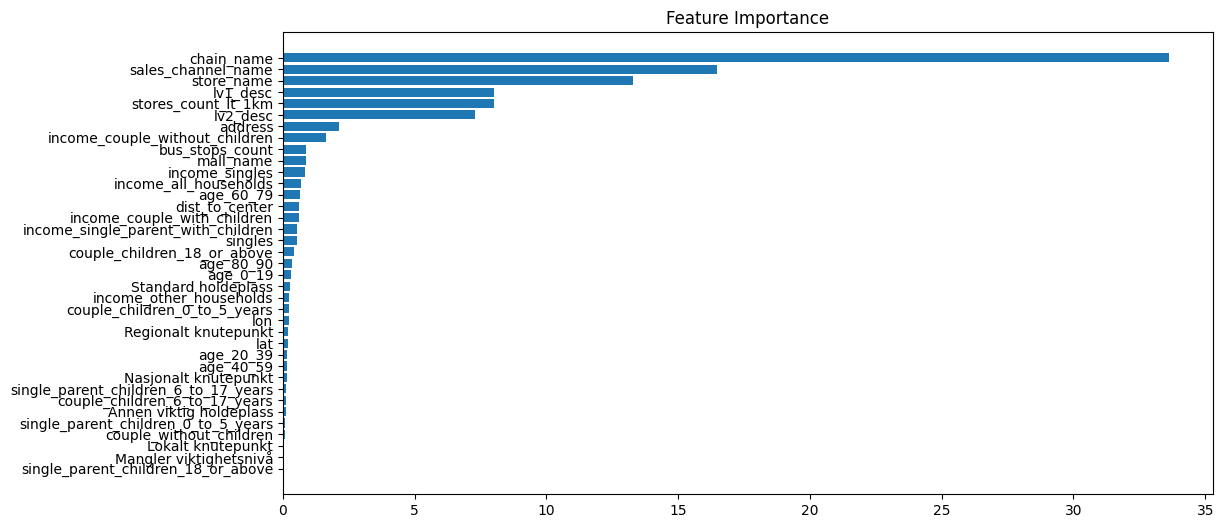

In [ ]:
feature_importance = cbm.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test_cb.columns)[sorted_idx])
plt.title('Feature Importance')

### Making predictions with LightGBM

In [ ]:
non_tunable_lgb_params, tunable_lgb_params = get_hyper_parameters(get_lgb_params, n_trials=400)

dtrain_lgb, dvalid_lgb = get_lgb_dmatrices()
lgbm = lgb.train(
    params={**non_tunable_lgb_params, **tunable_lgb_params},
    train_set=dtrain_lgb,
    valid_sets=dvalid_lgb,
    verbose_eval=False
)
y_val_pred = np.expm1(lgbm.predict(X_val_lgb))
score = rmsle(np.expm1(y_val), y_val_pred)
print(score)

# lgbm_model.booster_.save_model(f'models/lgbm/{score:.5f}')

In [ ]:
# cbm.fit(train_pool, eval_set=valid_pool, verbose=50, plot=True, early_stopping_rounds=100)
y_pred = np.expm1(cbm.predict(X_val_cb))
print(rmsle(np.expm1(y_val), y_pred))
y_pred_test = np.expm1(cbm.predict(X_test_cb))
submission['predicted'] = y_pred_test
submission.to_csv('submissions/submission_cbm2.csv', index=False)
# model.save_model(f'models/lgbm/{model.best_score_["validation"]["RMSE"]:.5f}')

In [ ]:
dtrain_lgb, dvalid_lgb = get_lgb_dmatrices()
lgbm = lgb.train(
    params={**get_lgb_params()[1], **{'lambda_l1': 0.026873437304227192, 'lambda_l2': 9.270495297846024, 'num_leaves': 7, 'feature_fraction': 0.8633788253368204, 'min_child_samples': 81, 'boosting_type': 'gbdt'}},
    train_set=dtrain_lgb,
    valid_sets=dvalid_lgb,
    verbose_eval=False
)
y_val_pred = np.expm1(lgbm.predict(X_val_lgb))
score = rmsle(np.expm1(y_val), y_val_pred)
print(score)

# lgbm.fit(X_train_lgb, y_train)
y_pred = np.expm1(lgbm.predict(X_val_lgb))
print(rmsle(np.expm1(y_val), y_pred))
y_pred_test = np.expm1(lgbm.predict(X_test_lgb))
submission['predicted'] = y_pred_test
submission.to_csv('submissions/submission_lgbm2.csv', index=False)
# # model.save_model(f'models/lgbm/{model.best_score_["validation"]["RMSE"]:.5f}')